# DSCI 100 Project - Section 6 Group 16 
# Minecraft project report 
## members:

|Name|Student Number|
|--------|---------|
|Clement Cheung|40162752|
|Eileen Limneus|81033300|
|Min Hyung Yoo|26944660|
|Tyler Lee|12253688|


### Project Objectives!
+ **Broad Question:** (1) What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

+ **Specific Question:** How does a player's tendency to revisit the PLAICraft server, and their total playtime affect their subscription status to a game-related newsletter?

In [1]:
# loading the 

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

+ relevant background information on the topic enough so that somoneone that is unfamiliar on it can understand the full report.
+ clearly state the question you tried to answer with your project
+ identify and fully describe the dataset that was used to answer the question

## Methods & Results

* describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
* your report should include code which:
    - loads data 
    - wrangles and cleans the data to the format necessary for the planned analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    - performs the data analysis
    - creates a visualization of the analysis
 
note: all figures should have a figure number and a legend

#### reading the data

In [2]:
session_data <- read_csv("sessions.csv")
players_data <- read_csv("players.csv")
session_data
players_data

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### processing session_data and merging the two dataframes

In [3]:
session_data <- session_data |> 
group_by(hashedEmail) |>
summarise(count = n()) |>
arrange(-count)
session_data

hashedEmail,count
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1


In [4]:
final_data <- full_join(session_data, players_data, by = "hashedEmail")
final_data

hashedEmail,count,experience,subscribe,played_hours,name,gender,Age
<chr>,<int>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,Amateur,TRUE,56.1,Dana,Male,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219,Regular,TRUE,223.1,Hiroshi,Male,17
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159,Amateur,TRUE,150.0,Delara,Female,16
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7,NA,Amateur,FALSE,0,Orion,Male,17
644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,NA,Amateur,TRUE,0,Rhys,Male,20
b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,NA,Amateur,TRUE,0,Bailey,Female,17


#### simple visualisation to get started

Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”


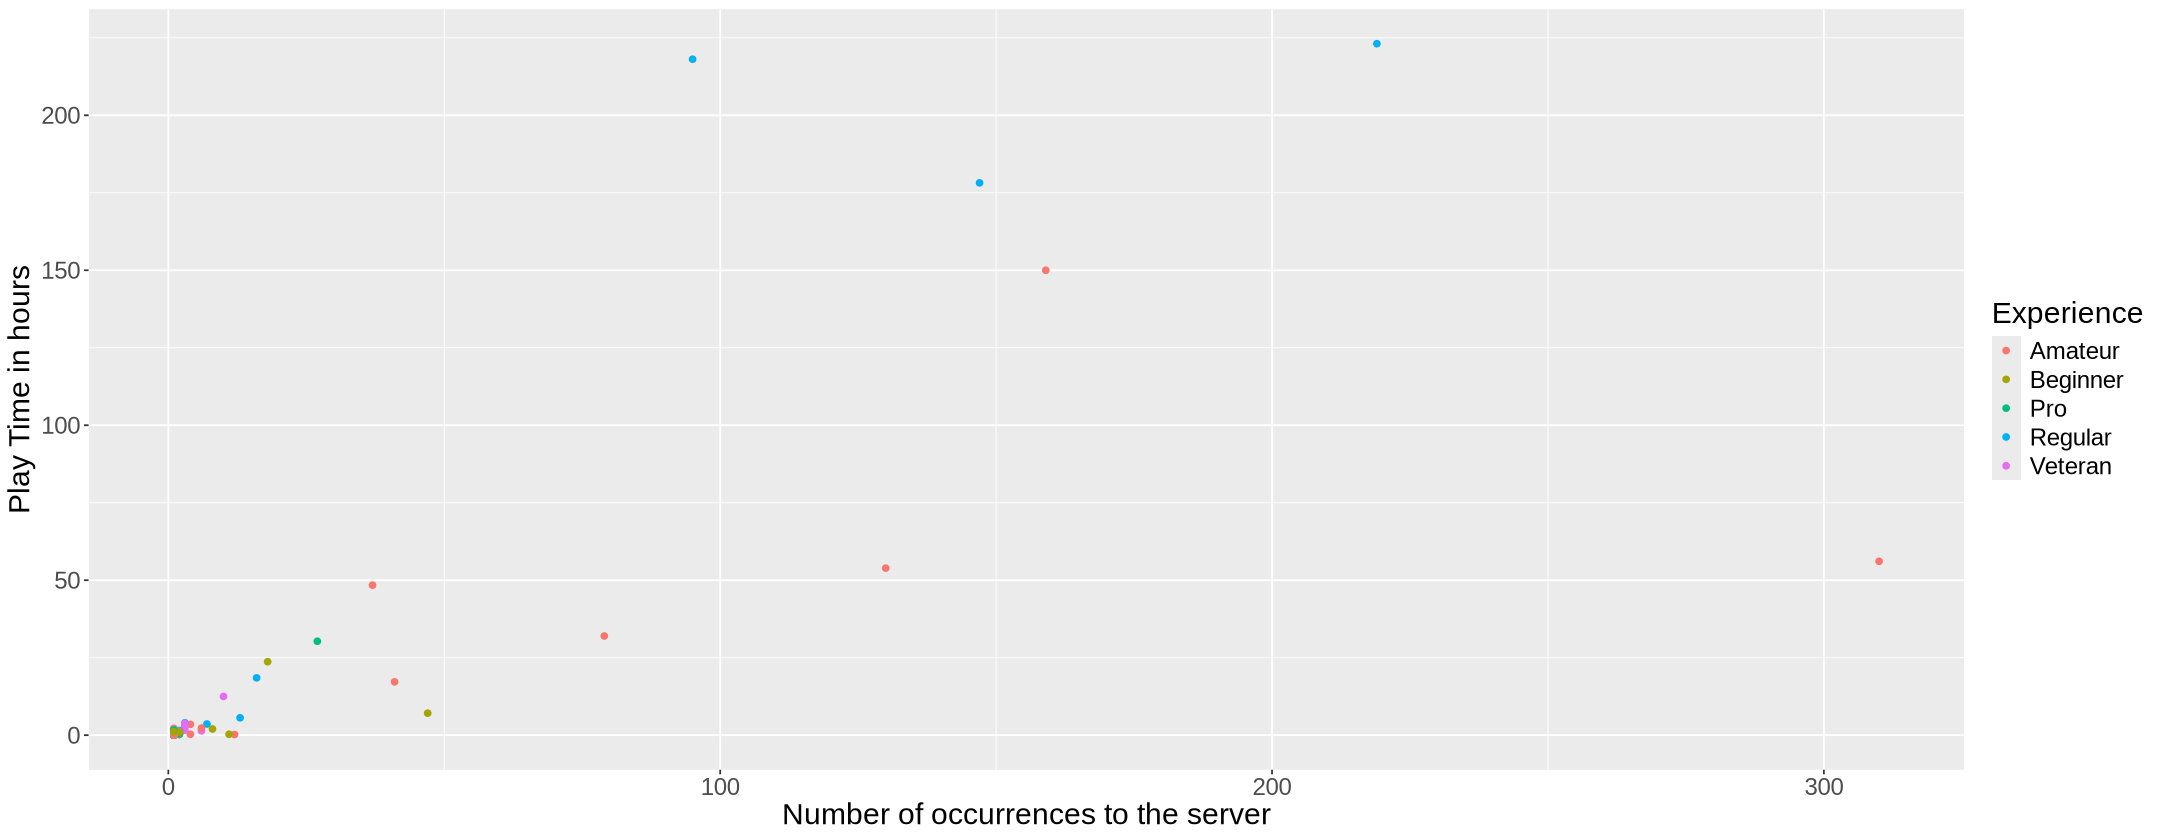

In [30]:
options(repr.plot.width = 18, repr.plot.height = 7)

final_data |>  
    ggplot(aes(x = count, y = played_hours, color = experience)) + 
    geom_point() + 
    xlab("Number of occurrences to the server") +
    ylab("Play Time in hours") +
    labs(color = "Experience") +
    theme(text = element_text(size = 18))



#### At this point...
Given the plot above, it's difficult to draw any conclusions on trends and patterns due to the various outliers skewing distribution. 

Warning message:
“Removed 71 rows containing missing values or values outside the scale range
(`geom_point()`).”


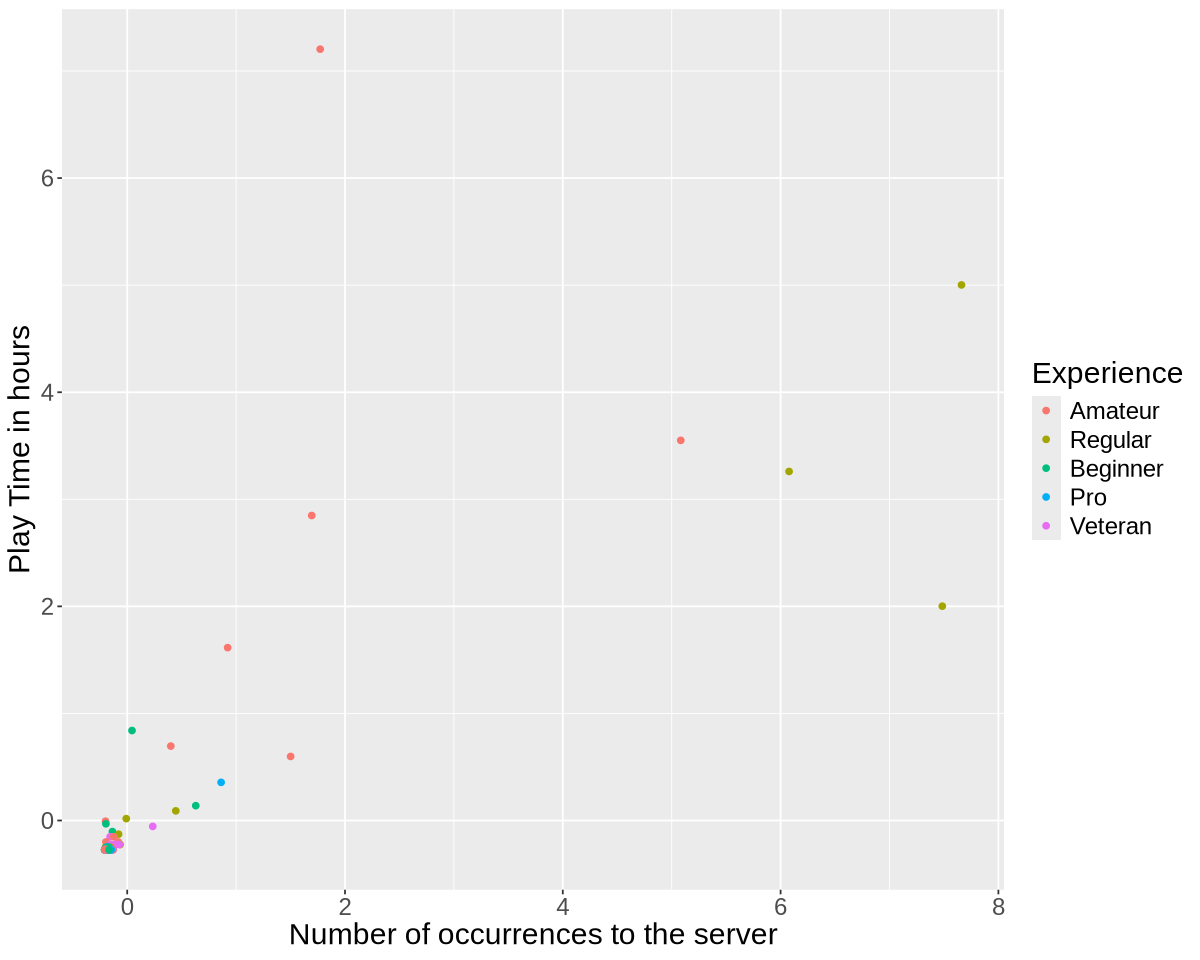

In [45]:
#plotting distributions for both the explanatory variables to determine an appropriate point to 'filter' 

options(repr.plot.width = 10, repr.plot.height = 8)

experience_class_data <- final_data |>
    mutate(experience = as_factor(experience)) |>
    select(experience, played_hours, count)

normalise_recipe <- experience_class_data |>
    recipe(experience ~ played_hours + count) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()
normalised_data <- bake(normalise_recipe, experience_class_data)

normalised_plot <- ggplot(normalised_data, aes(x = played_hours, y = count, colour = experience)) +
    geom_point() +
    xlab("Number of occurrences to the server") +
    ylab("Play Time in hours") +
    labs(color = "Experience") +
    theme(text = element_text(size = 18))
normalised_plot

As even normalising the data 

## Discussion

* summary of findings
* discuss if results were expected
* impact of the findings
* further questions to ask

## References

* any format so long as its a consistent citation style

In [13]:
?boxplot

boxplot {graphics},R Documentation
formula,"a formula, such as y ~ grp, where y is a numeric vector of data values to be split into groups according to the grouping variable grp (usually a factor). Note that ~ g1 + g2 is equivalent to g1:g2."
data,a data.frame (or list) from which the variables in formula should be taken.
subset,an optional vector specifying a subset of observations to be used for plotting.
na.action,a function which indicates what should happen when the data contain NAs. The default is to ignore missing values in either the response or the group.
"xlab, ylab","x- and y-axis annotation, since R 3.6.0 with a non-empty default. Can be suppressed by ann=FALSE."
ann,logical indicating if axes should be annotated (by xlab and ylab).
"drop, sep, lex.order","passed to split.default, see there."
x,"for specifying data from which the boxplots are to be produced. Either a numeric vector, or a single list containing such vectors. Additional unnamed arguments specify further data as separate vectors (each corresponding to a component boxplot). NAs are allowed in the data."
...,"For the formula method, named arguments to be passed to the default method. For the default method, unnamed arguments are additional data vectors (unless x is a list when they are ignored), and named arguments are arguments and graphical parameters to be passed to bxp in addition to the ones given by argument pars (and override those in pars). Note that bxp may or may not make use of graphical parameters it is passed: see its documentation."
range,"this determines how far the plot whiskers extend out from the box. If range is positive, the whiskers extend to the most extreme data point which is no more than range times the interquartile range from the box. A value of zero causes the whiskers to extend to the data extremes."
